In [1]:
# Import a file containing all the needed functions.
import os
from utils import *
import matplotlib.pyplot as plt

# Automatic reload the changes in `utils.py`.
# %load_ext autoreload
# %autoreload 2

# Import and pre-process the data

In [2]:
DATA_DIR = "c:/Users/bibli/classification/storage/dataCollections/"

# Folder for the objective/subjective reviews.
SUBJ_DIR = os.path.join(DATA_DIR, "subjectivity_dataset/quote.tok.gt9.5000")
OBJ_DIR = os.path.join(DATA_DIR, "subjectivity_dataset/plot.tok.gt9.5000")

# Folder for the positive/negative reviews.
POS_DIR = os.path.join(DATA_DIR, "sentiment_polarity/rt-polaritydata/rt-polarity.pos")
NEG_DIR = os.path.join(DATA_DIR, "sentiment_polarity/rt-polaritydata/rt-polarity.neg")

In [3]:
enc = 'latin-1'

# Load the objective/subjective reviews.
# Attach 0/1 tags for subjective/objective reviews.
subj_reviews = [[line.rstrip('\n'), '0'] for line in open(SUBJ_DIR, encoding=enc)]
obj_reviews = [[line.rstrip('\n'), '1'] for line in open(OBJ_DIR, encoding=enc)]

# Combine datasets
subj_data = subj_reviews + obj_reviews

# Load the positive/negative reviews.
# Attach 0/1 tags for negative/positive reviews.
neg_reviews = [[line.rstrip('\n'), '0'] for line in open(NEG_DIR, encoding=enc)]
pos_reviews = [[line.rstrip('\n'), '1'] for line in open(POS_DIR, encoding=enc)]

# Combine datasets
sent_data = pos_reviews + neg_reviews

In [4]:
# Tokenike subj. data.
subj_data_text = [subj_data[k][0] for k in range(len(subj_data))]  # Extract text
tok_subj_data = [tokenize_text(sent) for sent in subj_data_text]   # Tokenized data

# Tokenike sent. data.
sent_data_text = [sent_data[k][0] for k in range(len(sent_data))]  # Extract text
tok_sent_data = [tokenize_text(sent) for sent in sent_data_text]   # Tokenized data

# If everything works, delete the original datasets to save RAM.
if (len(tok_subj_data) == len(subj_data_text)):
    print("Tokenization of subj. data OK; original dataset removed.")
    del subj_data_text, subj_reviews, obj_reviews
    
if (len(tok_sent_data) == len(sent_data_text)):
    print("Tokenization of sent. data OK; original dataset removed.")    
    del sent_data_text, pos_reviews, neg_reviews

Tokenization of subj. data OK; original dataset removed.
Tokenization of sent. data OK; original dataset removed.


In [5]:
# Append ground truth labels.
tok_subj_data = [[tok_subj_data[k], subj_data[k][1]] for k in range(len(subj_data))]
tok_sent_data = [[tok_sent_data[k], sent_data[k][1]] for k in range(len(sent_data))]

#### Fixed parameters

In [6]:
n_top = 50     # Number of topics for LSI and LDA.
               # Vector dimension for cBow and PV.
mix_comp = 15  # Mixture components.
n_feat = 5000  # Number of features.

n_top_high = 50  # For computations with 100-dim. feat. vectors.

## 1. TF-IDF

First, let's look at a single point in parameter space and get the accuracy.

In [13]:
# Use 4-fold CV for this example (faster).
subj_res_tfidf = k_fold_BoW(tok_subj_data, vectorizer=TfidfVectorizer, features=n_feat, k=4, reg=1) 
sent_res_tfidf = k_fold_BoW(tok_sent_data, vectorizer=TfidfVectorizer, features=n_feat, k=4, reg=1)

print(" ------- TF-IDF ------- \n")
print(np.round(subj_res_tfidf, decimals=3))
print(np.round(sent_res_tfidf, decimals=3))

print("\n")

print("Mean subj. accuracy: {0:.3f} +/- {1:.3f}".format(np.mean(subj_res_tfidf), np.std(subj_res_tfidf)))
print("Mean sent. accuracy: {0:.3f} +/- {1:.3f}".format(np.mean(sent_res_tfidf), np.std(sent_res_tfidf)))

 ------- TF-IDF ------- 

[0.888 0.89  0.887 0.878]
[0.75  0.75  0.741 0.751]


Mean subj. accuracy: 0.886 +/- 0.005
Mean sent. accuracy: 0.748 +/- 0.004


#### Parameter scan - ragularization

## 2. LSI

First, let's look at a single point in parameter space and get the accuracy.

In [14]:
# Use 4-fold CV for this example (faster).
subj_res_LSI = k_fold_LSI(tok_subj_data, topics=n_top, k=4, reg=1)
sent_res_LSI = k_fold_LSI(tok_sent_data, topics=n_top, k=4, reg=1)

print(" ------- LSI ------- \n")
print(np.round(subj_res_LSI, decimals=3))
print(np.round(sent_res_LSI, decimals=3))

print("\n")

print("Mean subj. accuracy: {0:.3f} +/- {1:.3f}".format(np.mean(subj_res_LSI), np.std(subj_res_LSI)))
print("Mean sent. accuracy: {0:.3f} +/- {1:.3f}".format(np.mean(sent_res_LSI), np.std(sent_res_LSI)))

 ------- LSI ------- 

[0.805 0.819 0.826 0.822]
[0.645 0.603 0.644 0.616]


Mean subj. accuracy: 0.818 +/- 0.008
Mean sent. accuracy: 0.627 +/- 0.018


#### Parameter scan - ragularization

In [15]:
# Try several regularization parameters

# Here C in [0.01, 100]
a_lim = -2.0  # Lower limit: 10^{-2}
b_lim = 2     # Upper limit: 10^{+2}

reg_values_LSI = []  # C values for log. regr.
acc_subj_LSI = []    # mean accuracy on Subj. dataset
std_subj_LSI = []    # std on Subj. dataset
acc_sent_LSI = []    # mean accuracy on MR dataset
std_sent_LSI = []    # std on MR dataset

for i, r_exp in enumerate(np.linspace(a_lim, b_lim, 20)):
    r = 10**r_exp  # log. sampling in [0.01, 100]
    
    if i % 2 == 0:
        print("Processing C = {0:.3f}.".format(r))
    
    subj_res = k_fold_LSI(tok_subj_data, topics=n_top_high, k=10, reg=r)
    sent_res = k_fold_LSI(tok_sent_data, topics=n_top_high, k=10, reg=r)
    
    reg_values_LSI.append(r)
    acc_subj_LSI.append(np.mean(subj_res))
    std_subj_LSI.append(np.std(subj_res))
    acc_sent_LSI.append(np.mean(sent_res))
    std_sent_LSI.append(np.std(sent_res))
    
df_LSI = pd.DataFrame(list(zip(reg_values_LSI, acc_subj_LSI, std_subj_LSI, acc_sent_LSI, std_sent_LSI)), 
                      columns =['C_val', 'acc_subj', 'std_subj', 'acc_MR', 'std_MR'])

# Store the results in a .csv file.
df_LSI.round(4).to_csv('results/LSI_acc_reg_100topics.csv', header=True, index=False)

Processing C = 0.010.
Processing C = 0.026.
Processing C = 0.070.
Processing C = 0.183.
Processing C = 0.483.
Processing C = 1.274.
Processing C = 3.360.
Processing C = 8.859.
Processing C = 23.357.
Processing C = 61.585.


Take a look at the results.

In [16]:
# Import param. scan data.
df_LSI_50 = pd.read_csv("results/LSI_acc_reg.csv")
df_LSI_100 = pd.read_csv("results/LSI_acc_reg_100topics.csv")

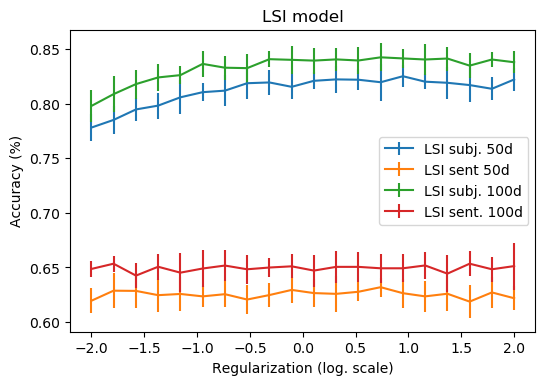

In [17]:
fig = plt.figure(dpi=100)

plt.errorbar(np.log10(df_LSI_50.C_val), df_LSI_50.acc_subj, yerr=df_LSI_50.std_subj, label='LSI subj. 50d')
plt.errorbar(np.log10(df_LSI_50.C_val), df_LSI_50.acc_MR, yerr=df_LSI_50.std_MR, label='LSI sent 50d')

plt.errorbar(np.log10(df_LSI_100.C_val), df_LSI_100.acc_subj, yerr=df_LSI_100.std_subj, label='LSI subj. 100d')
plt.errorbar(np.log10(df_LSI_100.C_val), df_LSI_100.acc_MR, yerr=df_LSI_100.std_MR, label='LSI sent. 100d')

plt.title('LSI model')
plt.xlabel('Regularization (log. scale)')
plt.ylabel('Accuracy (%)')

plt.legend()
plt.show()

## 3. LDA

First, let's look at a single point in parameter space and get the accuracy.

In [7]:
# Use 4-fold CV for this example (faster).
subj_res_LDA = k_fold_LDA(tok_subj_data, topics=n_top, k=4, reg=1)
sent_res_LDA = k_fold_LDA(tok_sent_data, topics=n_top, k=4, reg=1)

print(" ------- LDA ------- \n")
print(np.round(subj_res_LDA, decimals=3))
print(np.round(sent_res_LDA, decimals=3))

print("\n")

print("Mean subj. accuracy: {0:.3f} +/- {1:.3f}".format(np.mean(subj_res_LDA), np.std(subj_res_LDA)))
print("Mean sent. accuracy: {0:.3f} +/- {1:.3f}".format(np.mean(sent_res_LDA), np.std(sent_res_LDA)))

 ------- LDA ------- 

[0.549 0.564 0.568 0.578]
[0.546 0.541 0.534 0.522]


Mean subj. accuracy: 0.565 +/- 0.010
Mean sent. accuracy: 0.536 +/- 0.009


#### Parameter scan - number of passes

In [8]:
# Try several numbers of epochs

# Here epochs in [10, 100]
min_passes = 20
max_passes = 100
pass_step = 10

pass_values_LDA = []  # Number of epochs
acc_subj_LDA = []    # mean accuracy on Subj. dataset
std_subj_LDA = []    # std on Subj. dataset
acc_sent_LDA = []    # mean accuracy on MR dataset
std_sent_LDA = []    # std on MR dataset

for p in np.arange(min_passes, max_passes + pass_step, pass_step):
    
    print("Processing pass = {}.".format(p))
    
    subj_res = k_fold_LDA(tok_subj_data, topics=n_top_high, passes=p, chunksize=1000, k=10, reg=1)
    sent_res = k_fold_LDA(tok_sent_data, topics=n_top_high, passes=p, chunksize=1000, k=10, reg=1)
    
    pass_values_LDA.append(p)
    acc_subj_LDA.append(np.mean(subj_res))
    std_subj_LDA.append(np.std(subj_res))
    acc_sent_LDA.append(np.mean(sent_res))
    std_sent_LDA.append(np.std(sent_res))
    
    
df_LDA = pd.DataFrame(list(zip(pass_values_LDA, acc_subj_LDA, std_subj_LDA, acc_sent_LDA, std_sent_LDA)), 
                      columns =['pass_val', 'acc_subj', 'std_subj', 'acc_MR', 'std_MR'])

# Store the results in a .csv file.
df_LDA.round(4).to_csv('results/LDA_acc_passes_topics.csv', header=True, index=False)

Processing pass = 20.
Processing pass = 30.
Processing pass = 40.
Processing pass = 50.
Processing pass = 60.
Processing pass = 70.
Processing pass = 80.
Processing pass = 90.
Processing pass = 100.


Take a look at the results.

In [9]:
df_LDA_50 = pd.read_csv("results/LDA_acc_passes.csv")
df_LDA_100 = pd.read_csv("results/LDA_acc_passes_100topics.csv")

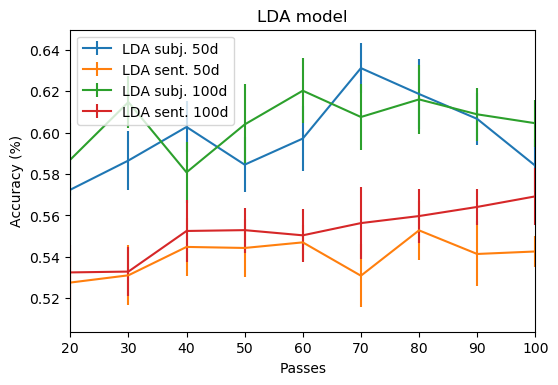

In [10]:
fig = plt.figure(dpi=100)

plt.errorbar(df_LDA_50.pass_val, df_LDA_50.acc_subj, yerr=df_LDA_50.std_subj, label='LDA subj. 50d')
plt.errorbar(df_LDA_50.pass_val, df_LDA_50.acc_MR, yerr=df_LDA_50.std_MR, label='LDA sent. 50d')

plt.errorbar(df_LDA_100.pass_val, df_LDA_100.acc_subj, yerr=df_LDA_100.std_subj, label='LDA subj. 100d')
plt.errorbar(df_LDA_100.pass_val, df_LDA_100.acc_MR, yerr=df_LDA_100.std_MR, label='LDA sent. 100d')

plt.xlim(20, 100)

plt.title('LDA model')
plt.xlabel('Passes')
plt.ylabel('Accuracy (%)')

plt.legend()
plt.show()

#### Parameter scan - ragularization

In [11]:
# Try several regularization parameters

# Here C in [0.01, 100]
a_lim = -2.0  # Lower limit: 10^{-2}
b_lim = 2     # Upper limit: 10^{+2}

reg_values_LDA = []  # C values for log. regr.
acc_subj_LDA = []    # mean accuracy on Subj. dataset
std_subj_LDA = []    # std on Subj. dataset
acc_sent_LDA = []    # mean accuracy on MR dataset
std_sent_LDA = []    # std on MR dataset

for i, r_exp in enumerate(np.linspace(a_lim, b_lim, 20)):
    r = 10**r_exp  # log. sampling in [0.01, 100]
    
    if i % 2 == 0:
        print("Processing C = {0:.3f}.".format(r))
    
    subj_res = k_fold_LDA(tok_subj_data, topics=n_top_high, passes=70, chunksize=1000, k=10, reg=r)
    sent_res = k_fold_LDA(tok_sent_data, topics=n_top_high, passes=80, chunksize=1000, k=10, reg=r)
    
    reg_values_LDA.append(r)
    acc_subj_LDA.append(np.mean(subj_res))
    std_subj_LDA.append(np.std(subj_res))
    acc_sent_LDA.append(np.mean(sent_res))
    std_sent_LDA.append(np.std(sent_res))
    
df_LDA = pd.DataFrame(list(zip(reg_values_LDA, acc_subj_LDA, std_subj_LDA, acc_sent_LDA, std_sent_LDA)), 
                      columns =['C_val', 'acc_subj', 'std_subj', 'acc_MR', 'std_MR'])

# Store the results in a .csv file.
df_LDA.round(4).to_csv('results/LDA_acc_reg_topics.csv', header=True, index=False)        

Processing C = 0.010.
Processing C = 0.026.
Processing C = 0.070.
Processing C = 0.183.
Processing C = 0.483.
Processing C = 1.274.
Processing C = 3.360.
Processing C = 8.859.
Processing C = 23.357.
Processing C = 61.585.


Take a look at the results.

In [12]:
# Import param. scan data.
df_LDA_50 = pd.read_csv("results/LDA_acc_reg.csv")
df_LDA_100 = pd.read_csv("results/LDA_acc_reg_100topics.csv")

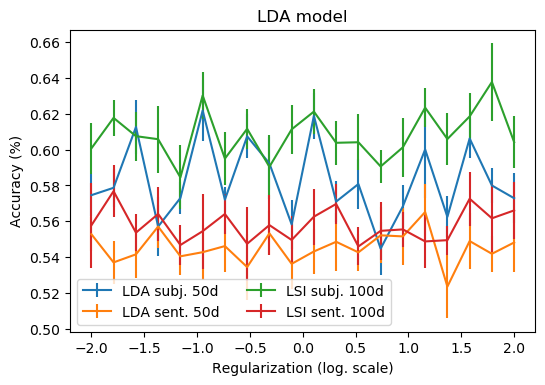

In [13]:
fig = plt.figure(dpi=100)

plt.errorbar(np.log10(df_LDA_50.C_val), df_LDA_50.acc_subj, yerr=df_LDA_50.std_subj, label='LDA subj. 50d')
plt.errorbar(np.log10(df_LDA_50.C_val), df_LDA_50.acc_MR, yerr=df_LDA_50.std_MR, label='LDA sent. 50d')

plt.errorbar(np.log10(df_LDA_100.C_val), df_LDA_100.acc_subj, yerr=df_LDA_100.std_subj, label='LSI subj. 100d')
plt.errorbar(np.log10(df_LDA_100.C_val), df_LDA_100.acc_MR, yerr=df_LDA_100.std_MR, label='LSI sent. 100d')

plt.title('LDA model')
plt.xlabel('Regularization (log. scale)')
plt.ylabel('Accuracy (%)')

plt.legend(loc=3, ncol=2)
plt.show()

## 4. cBow

First, let's look at a single point in parameter space and get the accuracy.

In [37]:
# Use 4-fold CV for this example (faster).
subj_res_cBow = k_fold_cBow(tok_subj_data, v_size=n_top, k=4, reg=1)
sent_res_cBow = k_fold_cBow(tok_sent_data, v_size=n_top, k=4, reg=1)

print(" ------- cBow ------- \n")
print(np.round(subj_res_cBow, decimals=3))
print(np.round(sent_res_cBow, decimals=3))

print("\n")

print("Mean subj. accuracy: {0:.3f} +/- {1:.3f}".format(np.mean(subj_res_cBow), np.std(subj_res_cBow)))
print("Mean sent. accuracy: {0:.3f} +/- {1:.3f}".format(np.mean(sent_res_cBow), np.std(sent_res_cBow)))

 ------- cBow ------- 

[0.857 0.867 0.864 0.854]
[0.638 0.641 0.635 0.631]


Mean subj. accuracy: 0.861 +/- 0.005
Mean sent. accuracy: 0.636 +/- 0.004


#### Parameter scan - epochs

In [38]:
# Try several numbers of epochs

# Here epochs in [10, 100]
min_epoch = 20
max_epoch = 100
ep_step = 10

epoch_values_cBow = []  # Number of epochs
acc_subj_cBow2 = []     # mean accuracy on Subj. dataset
std_subj_cBow2 = []     # std on Subj. dataset
acc_sent_cBow2 = []     # mean accuracy on MR dataset
std_sent_cBow2 = []     # std on MR dataset

for ep in np.arange(min_epoch, max_epoch + ep_step, ep_step):
    
    print("Processing epoch = {}".format(ep))
    
    subj_res = k_fold_cBow(tok_subj_data, v_size=n_top_high, epochs=ep, k=10, reg=10)
    sent_res = k_fold_cBow(tok_sent_data, v_size=n_top_high, epochs=ep, k=10, reg=10)
    
    epoch_values_cBow.append(ep)
    acc_subj_cBow2.append(np.mean(subj_res))
    std_subj_cBow2.append(np.std(subj_res))
    acc_sent_cBow2.append(np.mean(sent_res))
    std_sent_cBow2.append(np.std(sent_res))
    
    
df_cBow = pd.DataFrame(list(zip(epoch_values_cBow, acc_subj_cBow2, std_subj_cBow2, acc_sent_cBow2, std_sent_cBow2)), 
                       columns =['epoch', 'acc_subj', 'std_subj', 'acc_MR', 'std_MR'])

# Store the results in a .csv file.
df_cBow.round(4).to_csv('results/cBow_acc_ep_reg_10_100topics.csv.csv', header=True, index=False)

Processing epoch = 20
Processing epoch = 30
Processing epoch = 40
Processing epoch = 50
Processing epoch = 60
Processing epoch = 70
Processing epoch = 80
Processing epoch = 90
Processing epoch = 100


Take a look at the results.

In [39]:
df_cBow_50 = pd.read_csv("results/cBow_acc_ep_reg_10.csv")
df_cBow_100 = pd.read_csv("results/cBow_acc_ep_reg_10_100topics.csv")

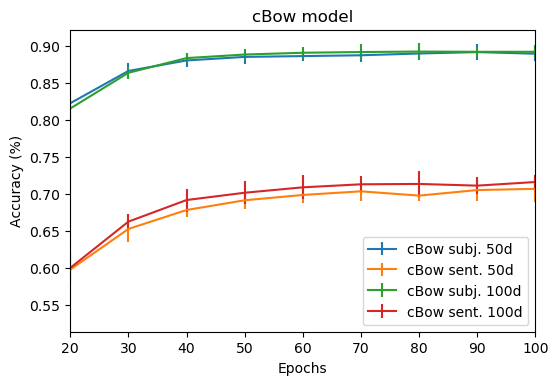

In [40]:
fig = plt.figure(dpi=100)

plt.errorbar(df_cBow_50.epoch, df_cBow_50.acc_subj, yerr=df_cBow_50.std_subj, label='cBow subj. 50d')
plt.errorbar(df_cBow_50.epoch, df_cBow_50.acc_MR, yerr=df_cBow_50.std_MR, label='cBow sent. 50d')

plt.errorbar(df_cBow_100.epoch, df_cBow_100.acc_subj, yerr=df_cBow_100.std_subj, label='cBow subj. 100d')
plt.errorbar(df_cBow_100.epoch, df_cBow_100.acc_MR, yerr=df_cBow_100.std_MR, label='cBow sent. 100d')

plt.xlim(20, 100)

plt.title('cBow model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.legend()
plt.show()

#### Parameter scan - ragularization

In [41]:
# Try several regularization parameters


# Here C in [0.01, 100]
a_lim = -2.0  # Lower limit: 10^{-2}
b_lim = 2     # Upper limit: 10^{+2}

reg_values_cBow = []  # C values for log. regr.
acc_subj_cBow = []    # mean accuracy on Subj. dataset
std_subj_cBow = []    # std on Subj. dataset
acc_sent_cBow = []    # mean accuracy on MR dataset
std_sent_cBow = []    # std on MR dataset

for i, r_exp in enumerate(np.linspace(a_lim, b_lim, 20)):
    r = 10**r_exp  # log. sampling in [0.01, 100]
    
    if i % 2 == 0:
        print("Processing C = {0:.3f}.".format(r))
    
    subj_res = k_fold_cBow(tok_subj_data, v_size=n_top_high, epochs=70, k=10, reg=r)
    sent_res = k_fold_cBow(tok_sent_data, v_size=n_top_high, epochs=70, k=10, reg=r)
    
    reg_values_cBow.append(r)
    acc_subj_cBow.append(np.mean(subj_res))
    std_subj_cBow.append(np.std(subj_res))
    acc_sent_cBow.append(np.mean(sent_res))
    std_sent_cBow.append(np.std(sent_res))
    

df_cBow = pd.DataFrame(list(zip(reg_values_cBow, acc_subj_cBow, std_subj_cBow, acc_sent_cBow, std_sent_cBow)), 
                       columns =['C_val', 'acc_subj', 'std_subj', 'acc_MR', 'std_MR'])

# Store the results in a .csv file.
df_cBow.round(4).to_csv('results/cBow_acc_reg_70ep_100topics.csv', header=True, index=False)

Processing C = 0.010.
Processing C = 0.026.
Processing C = 0.070.
Processing C = 0.183.
Processing C = 0.483.
Processing C = 1.274.
Processing C = 3.360.
Processing C = 8.859.
Processing C = 23.357.
Processing C = 61.585.


Take a look at the results.

In [42]:
df_cBow_50 = pd.read_csv("results/cBow_acc_reg_60ep.csv")
df_cBow_100 = pd.read_csv("results/cBow_acc_reg_70ep_100topics.csv")

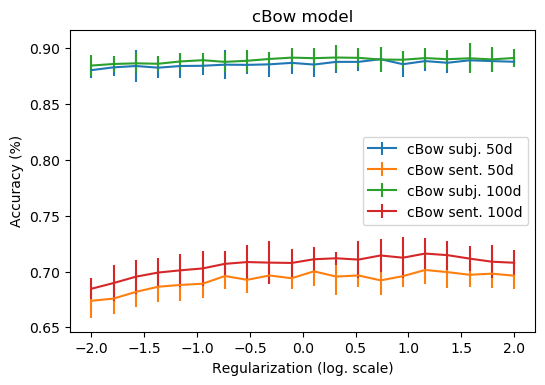

In [43]:
fig = plt.figure(dpi=100)

plt.errorbar(np.log10(df_cBow_50.C_val), df_cBow_50.acc_subj, yerr=df_cBow_50.std_subj, label='cBow subj. 50d')
plt.errorbar(np.log10(df_cBow_50.C_val), df_cBow_50.acc_MR, yerr=df_cBow_50.std_MR, label='cBow sent. 50d')

plt.errorbar(np.log10(df_cBow_100.C_val), df_cBow_100.acc_subj, yerr=df_cBow_100.std_subj, label='cBow subj. 100d')
plt.errorbar(np.log10(df_cBow_100.C_val), df_cBow_100.acc_MR, yerr=df_cBow_100.std_MR, label='cBow sent. 100d')

plt.title('cBow model')
plt.xlabel('Regularization (log. scale)')
plt.ylabel('Accuracy (%)')

plt.legend()
plt.show()

## 5. PV-based models

First, let's look at a single point in parameter space and get the accuracy.

In [12]:
# Use 4-fold CV for this example (faster).
subj_res_DBOW, subj_res_DM = k_fold_PV(tok_subj_data, v_size=n_top, k=4, reg=1)
sent_res_DBOW, sent_res_DM = k_fold_PV(tok_sent_data, v_size=n_top, k=4, reg=1)

print(" ------- PV-DBOW ------- \n")
print(np.round(subj_res_DBOW, decimals=3))
print(np.round(sent_res_DBOW, decimals=3))

print("\n")
print(" ------- PV-DM ------- \n")
print(np.round(subj_res_DM, decimals=3))
print(np.round(sent_res_DM, decimals=3))

print("\n")

print("Mean subj. accuracy:") 
print("PV-DBOW: {0:.3f} +/- {1:.3f}".format(np.mean(subj_res_DBOW), np.std(subj_res_DBOW)))
print("PV-DM: {0:.3f} +/- {1:.3f}".format(np.mean(subj_res_DM), np.std(subj_res_DM)))

print("\n")

print("Mean sent. accuracy:") 
print("PV-DBOW: {0:.3f} +/- {1:.3f}".format(np.mean(sent_res_DBOW), np.std(sent_res_DBOW)))
print("PV-DM: {0:.3f} +/- {1:.3f}".format(np.mean(sent_res_DM), np.std(sent_res_DM)))

Doc2Vec(dbow,d50,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d50,n5,w5,t4) Vocabulary ready for 
Training Doc2Vec(dbow,d50,n5,t4)
Training Doc2Vec(dm/m,d50,n5,w5,t4)
Doc2Vec(dbow,d50,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d50,n5,w5,t4) Vocabulary ready for 
Training Doc2Vec(dbow,d50,n5,t4)
Training Doc2Vec(dm/m,d50,n5,w5,t4)
 ------- PV-DBOW ------- 

[0.816 0.81  0.811 0.799]
[0.595 0.582 0.607 0.601]


 ------- PV-DM ------- 

[0.876 0.878 0.867 0.871]
[0.674 0.648 0.647 0.644]


Mean subj. accuracy:
PV-DBOW: 0.809 +/- 0.006
PV-DM: 0.873 +/- 0.004


Mean sent. accuracy:
PV-DBOW: 0.596 +/- 0.009
PV-DM: 0.653 +/- 0.012


#### Parameter scan - epochs

In [22]:
# Try several numbers of epochs

# Here epochs in [10, 100]
min_epoch = 20
max_epoch = 100
ep_step = 10

epoch_values_PV = []  # Number of epochs

acc_subj_DBOW = []    # mean accuracy on Subj. dataset of DBOW
std_subj_DBOW = []    # std on Subj. dataset of DBOW
acc_sent_DBOW = []    # mean accuracy on MR dataset of DBOW
std_sent_DBOW = []    # std on MR dataset of DBOW

acc_subj_DM = []      # mean accuracy on Subj. dataset of DM
std_subj_DM = []      # std on Subj. dataset of DM
acc_sent_DM = []      # mean accuracy on MR dataset of DM
std_sent_DM = []      # std on MR dataset of DM

#for ep in np.arange(min_epoch, max_epoch + ep_step, ep_step)

ep = []
x = range(min_epoch, max_epoch + ep_step, ep_step)
for n in x:
         
    ep += [n]
    
    print("Processing epoch = {}".format(ep))
    
    subj_res_DBOW, subj_res_DM = k_fold_PV(tok_subj_data, v_size=n_top_high, epochs=ep, k=10, reg=1)
    sent_res_DBOW, sent_res_DM = k_fold_PV(tok_sent_data, v_size=n_top_high, epochs=ep, k=10, reg=1)
    
    epoch_values_PV.append(ep)
    
    acc_subj_DBOW.append(np.mean(subj_res_DBOW))
    std_subj_DBOW.append(np.std(subj_res_DBOW))
    acc_sent_DBOW.append(np.mean(sent_res_DBOW))
    std_sent_DBOW.append(np.std(sent_res_DBOW))
    
    acc_subj_DM.append(np.mean(subj_res_DM))
    std_subj_DM.append(np.std(subj_res_DM))
    acc_sent_DM.append(np.mean(sent_res_DM))
    std_sent_DM.append(np.std(sent_res_DM))
    

df_DBOW = pd.DataFrame(list(zip(epoch_values_PV, acc_subj_DBOW, std_subj_DBOW, acc_sent_DBOW, std_sent_DBOW)), 
                       columns =['epoch', 'acc_subj', 'std_subj', 'acc_MR', 'std_MR'])

df_DM = pd.DataFrame(list(zip(epoch_values_PV, acc_subj_DM, std_subj_DM, acc_sent_DM, std_sent_DM)), 
                     columns =['epoch', 'acc_subj', 'std_subj', 'acc_MR', 'std_MR'])

# Store the results in a .csv file.
df_DBOW.round(4).to_csv('results/DBOW_acc_ep_reg1_100topics.csv', header=True, index=False)
df_DM.round(4).to_csv('results/DM_acc_ep_reg1_100topics.csv', header=True, index=False)

Processing epoch = [20]
Doc2Vec(dbow,d100,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d100,n5,w5,t4) Vocabulary ready for 
Training Doc2Vec(dbow,d100,n5,t4)
Training Doc2Vec(dm/m,d100,n5,w5,t4)
Doc2Vec(dbow,d100,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d100,n5,w5,t4) Vocabulary ready for 
Training Doc2Vec(dbow,d100,n5,t4)
Training Doc2Vec(dm/m,d100,n5,w5,t4)
Processing epoch = [20, 30]
Doc2Vec(dbow,d100,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d100,n5,w5,t4) Vocabulary ready for 
Training Doc2Vec(dbow,d100,n5,t4)
Training Doc2Vec(dm/m,d100,n5,w5,t4)
Doc2Vec(dbow,d100,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d100,n5,w5,t4) Vocabulary ready for 
Training Doc2Vec(dbow,d100,n5,t4)
Training Doc2Vec(dm/m,d100,n5,w5,t4)
Processing epoch = [20, 30, 40]
Doc2Vec(dbow,d100,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d100,n5,w5,t4) Vocabulary ready for 
Training Doc2Vec(dbow,d100,n5,t4)
Training Doc2Vec(dm/m,d100,n5,w5,t4)
Doc2Vec(dbow,d100,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d100,n5,w5,t4) V

Take a look at the results.

In [23]:
df_DBOW_50 = pd.read_csv("results/DBOW_acc_ep_reg1.csv")
df_DM_50 = pd.read_csv("results/DM_acc_ep_reg1.csv")
df_DBOW_100 = pd.read_csv("results/DBOW_acc_ep_reg1_100topics.csv")
df_DM_100 = pd.read_csv("results/DM_acc_ep_reg1_100topics.csv")

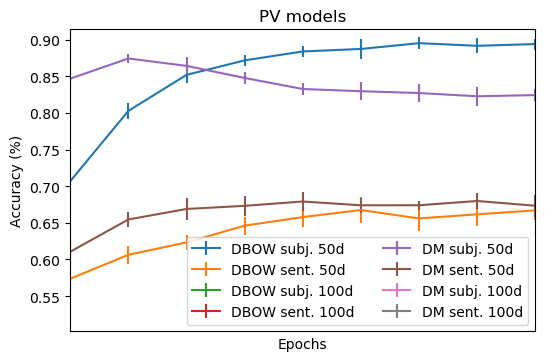

In [24]:
fig = plt.figure(dpi=100)

plt.errorbar(df_DBOW_50.epoch, df_DBOW_50.acc_subj, yerr=df_DBOW_50.std_subj, label='DBOW subj. 50d')
plt.errorbar(df_DBOW_50.epoch, df_DBOW_50.acc_MR, yerr=df_DBOW_50.std_MR, label='DBOW sent. 50d')

plt.errorbar(df_DBOW_100.epoch, df_DBOW_100.acc_subj, yerr=df_DBOW_100.std_subj, label='DBOW subj. 100d')
plt.errorbar(df_DBOW_100.epoch, df_DBOW_100.acc_MR, yerr=df_DBOW_100.std_MR, label='DBOW sent. 100d')

plt.errorbar(df_DM_50.epoch, df_DM_50.acc_subj, yerr=df_DM_50.std_subj, label='DM subj. 50d')
plt.errorbar(df_DM_50.epoch, df_DM_50.acc_MR, yerr=df_DM_50.std_MR, label='DM sent. 50d')

plt.errorbar(df_DM_100.epoch, df_DM_100.acc_subj, yerr=df_DM_100.std_subj, label='DM subj. 100d')
plt.errorbar(df_DM_100.epoch, df_DM_100.acc_MR, yerr=df_DM_100.std_MR, label='DM sent. 100d')

plt.xlim(20, 100)

plt.title('PV models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.legend(ncol=2)
plt.show()

#### Parameter scan - ragularization

In [ ]:
# Try several regularization parameters

# Here C in [0.01, 100]
a_lim = -2.0  # Lower limit: 10^{-2}
b_lim = 2     # Upper limit: 10^{+2}

reg_values_PV = []     # C values for log. regr.

acc_subj_DBOW2 = []    # mean accuracy on Subj. dataset of DBOW
std_subj_DBOW2 = []    # std on Subj. dataset of DBOW
acc_sent_DBOW2 = []    # mean accuracy on MR dataset of DBOW
std_sent_DBOW2 = []    # std on MR dataset of DBOW

acc_subj_DM2 = []      # mean accuracy on Subj. dataset of DM
std_subj_DM2 = []      # std on Subj. dataset of DM
acc_sent_DM2 = []      # mean accuracy on MR dataset of DM
std_sent_DM2 = []      # std on MR dataset of DM

for i, r_exp in enumerate(np.linspace(a_lim, b_lim, 20)):
    r = 10**r_exp  # log. sampling in [0.01, 100]
    
    if i % 2 == 0:
        print("Processing C = {0:.3f}.".format(r))
    
    subj_res_DBOW2, subj_res_DM2 = k_fold_PV(tok_subj_data, v_size=n_top_high, epochs=[70, 30], k=10, reg=r)
    sent_res_DBOW2, sent_res_DM2 = k_fold_PV(tok_sent_data, v_size=n_top_high, epochs=[60], k=10, reg=r)
        
    reg_values_PV.append(r)
   
    acc_subj_DBOW2.append(np.mean(subj_res_DBOW2))
    std_subj_DBOW2.append(np.std(subj_res_DBOW2))
    acc_sent_DBOW2.append(np.mean(sent_res_DBOW2))
    std_sent_DBOW2.append(np.std(sent_res_DBOW2))
    
    acc_subj_DM2.append(np.mean(subj_res_DM2))
    std_subj_DM2.append(np.std(subj_res_DM2))
    acc_sent_DM2.append(np.mean(sent_res_DM2))
    std_sent_DM2.append(np.std(sent_res_DM2))
    

df_DBOW2 = pd.DataFrame(list(zip(reg_values_PV, acc_subj_DBOW2, std_subj_DBOW2, acc_sent_DBOW2, std_sent_DBOW2)), 
                        columns =['C_val', 'acc_subj', 'std_subj', 'acc_MR', 'std_MR'])

df_DM2 = pd.DataFrame(list(zip(reg_values_PV, acc_subj_DM2, std_subj_DM2, acc_sent_DM2, std_sent_DM2)), 
                      columns =['C_val', 'acc_subj', 'std_subj', 'acc_MR', 'std_MR'])

# Store the results in a .csv file.
df_DBOW2.round(4).to_csv('results/DBOW_acc_reg_100topics.csv', header=True, index=False)
df_DM2.round(4).to_csv('results/DM_acc_reg_100topics.csv', header=True, index=False)

Processing C = 0.010.
Doc2Vec(dbow,d100,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d100,n5,w5,t4) Vocabulary ready for 
Training Doc2Vec(dbow,d100,n5,t4)
Training Doc2Vec(dm/m,d100,n5,w5,t4)
Doc2Vec(dbow,d100,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d100,n5,w5,t4) Vocabulary ready for 
Training Doc2Vec(dbow,d100,n5,t4)
Training Doc2Vec(dm/m,d100,n5,w5,t4)
Doc2Vec(dbow,d100,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d100,n5,w5,t4) Vocabulary ready for 
Training Doc2Vec(dbow,d100,n5,t4)
Training Doc2Vec(dm/m,d100,n5,w5,t4)
Doc2Vec(dbow,d100,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d100,n5,w5,t4) Vocabulary ready for 
Training Doc2Vec(dbow,d100,n5,t4)
Training Doc2Vec(dm/m,d100,n5,w5,t4)
Processing C = 0.026.
Doc2Vec(dbow,d100,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d100,n5,w5,t4) Vocabulary ready for 
Training Doc2Vec(dbow,d100,n5,t4)
Training Doc2Vec(dm/m,d100,n5,w5,t4)
Doc2Vec(dbow,d100,n5,t4) Vocabulary ready for 
Doc2Vec(dm/m,d100,n5,w5,t4) Vocabulary ready for 
Training Doc2Vec(db

Take a look at the results.

In [ ]:
df_DBOW_50 = pd.read_csv("results/DBOW_acc_reg.csv")
df_DM_50 = pd.read_csv("results/DM_acc_reg.csv")
df_DBOW_100 = pd.read_csv("results/DBOW_acc_reg_100topics.csv")
df_DM_100 = pd.read_csv("results/DM_acc_reg_100topics.csv")

In [ ]:
fig = plt.figure(dpi=100)

plt.errorbar(np.log10(df_DBOW_50.C_val), df_DBOW_50.acc_subj, yerr=df_DBOW_50.std_subj, label='DBOW subj. 50d')
plt.errorbar(np.log10(df_DBOW_50.C_val), df_DBOW_50.acc_MR, yerr=df_DBOW_50.std_MR, label='DBOW sent. 50d')

plt.errorbar(np.log10(df_DBOW_100.C_val), df_DBOW_100.acc_subj, yerr=df_DBOW_100.std_subj, label='DBOW subj. 100d')
plt.errorbar(np.log10(df_DBOW_100.C_val), df_DBOW_100.acc_MR, yerr=df_DBOW_100.std_MR, label='DBOW sent. 100d')

plt.errorbar(np.log10(df_DM_50.C_val), df_DM_50.acc_subj, yerr=df_DM_50.std_subj, label='DM subj. 50d')
plt.errorbar(np.log10(df_DM_50.C_val), df_DM_50.acc_MR, yerr=df_DM_50.std_MR, label='DM sent. 50d')

plt.errorbar(np.log10(df_DM_100.C_val), df_DM_100.acc_subj, yerr=df_DM_100.std_subj, label='DBOW subj. 100d')
plt.errorbar(np.log10(df_DM_100.C_val), df_DM_100.acc_MR, yerr=df_DM_100.std_MR, label='DBOW sent. 100d')

plt.title('PV models')
plt.xlabel('Regularization (log. scale)')
plt.ylabel('Accuracy (%)')

plt.legend(ncol=2)
plt.show()

## 6. FV-based models

First, let's look at a single point in parameter space and get the accuracy.

**First step**: train two cBow models, one on the subj. and one on the sent. dataset.

**Second step**: fit these two word embeddings with the mixture models.

In [27]:
path_w2v = 'models/cBow/'

subj_res = k_fold_cBow(tok_subj_data, save_path=path_w2v, name='subj', v_size=n_top_high, epochs=80, k=4, reg=1)
sent_res = k_fold_cBow(tok_sent_data, save_path=path_w2v, name='sent', v_size=n_top_high, epochs=80, k=4, reg=1)

2019-10-17 19:27:57,986 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-10-17 19:27:57,986 : INFO : collecting all words and their counts
2019-10-17 19:27:57,987 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-17 19:27:57,996 : INFO : PROGRESS: at sentence #5000, processed 59919 words, keeping 14013 word types
2019-10-17 19:27:58,008 : INFO : collected 22422 word types from a corpus of 124484 raw words and 10000 sentences
2019-10-17 19:27:58,008 : INFO : Loading a fresh vocabulary
2019-10-17 19:27:58,032 : INFO : effective_min_count=1 retains 22422 unique words (100% of original 22422, drops 0)
2019-10-17 19:27:58,032 : INFO : effective_min_count=1 leaves 124484 word corpus (100% of original 124484, drops 0)
2019-10-17 19:27:58,076 : INFO : deleting the raw counts dictionary of 22422 items
2019-10-17 19:27:58,077 : INFO : sample=0.001 downsamples 14 most-common words
2019-10-17 19:27:58,077 : INFO : downsampling

2019-10-17 19:27:59,279 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-17 19:27:59,284 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-17 19:27:59,291 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-17 19:27:59,291 : INFO : EPOCH - 13 : training on 124484 raw words (119834 effective words) took 0.1s, 1491965 effective words/s
2019-10-17 19:27:59,291 : INFO : Loss after epoch 12: 1217337.0
2019-10-17 19:27:59,377 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-17 19:27:59,378 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-17 19:27:59,382 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-17 19:27:59,386 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-17 19:27:59,387 : INFO : EPOCH - 14 : training on 124484 raw words (119742 effective words) took 0.1s, 1359267 effective words/s
2019-10-17 19:27:59,387 :

2019-10-17 19:28:00,463 : INFO : EPOCH - 27 : training on 124484 raw words (119812 effective words) took 0.1s, 1475797 effective words/s
2019-10-17 19:28:00,464 : INFO : Loss after epoch 26: 2232738.5
2019-10-17 19:28:00,544 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-17 19:28:00,548 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-17 19:28:00,553 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-17 19:28:00,561 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-17 19:28:00,562 : INFO : EPOCH - 28 : training on 124484 raw words (119748 effective words) took 0.1s, 1318164 effective words/s
2019-10-17 19:28:00,562 : INFO : Loss after epoch 27: 2298905.25
2019-10-17 19:28:00,632 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-17 19:28:00,643 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-17 19:28:00,644 : INFO : worker thread fini

2019-10-17 19:28:01,644 : INFO : saved trained_models/cBow_for_FV/word2vec_subj_epochs40_reg1.000.model
2019-10-17 19:28:01,645 : INFO : precomputing L2-norms of word weight vectors
2019-10-17 19:28:05,502 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-10-17 19:28:05,503 : INFO : collecting all words and their counts
2019-10-17 19:28:05,503 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-17 19:28:05,512 : INFO : PROGRESS: at sentence #5000, processed 55675 words, keeping 12812 word types
2019-10-17 19:28:05,521 : INFO : PROGRESS: at sentence #10000, processed 110584 words, keeping 19361 word types
2019-10-17 19:28:05,523 : INFO : collected 20112 word types from a corpus of 117899 raw words and 10662 sentences
2019-10-17 19:28:05,523 : INFO : Loading a fresh vocabulary
2019-10-17 19:28:05,544 : INFO : effective_min_count=1 retains 20112 unique words (100% of original 20112, drops 0)
2019-10-17 19:28:05,544 : INF

2019-10-17 19:28:06,591 : INFO : EPOCH - 12 : training on 117899 raw words (111226 effective words) took 0.1s, 1796200 effective words/s
2019-10-17 19:28:06,591 : INFO : Loss after epoch 11: 1049537.5
2019-10-17 19:28:06,651 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-17 19:28:06,652 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-17 19:28:06,656 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-17 19:28:06,663 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-17 19:28:06,664 : INFO : EPOCH - 13 : training on 117899 raw words (111309 effective words) took 0.1s, 1660454 effective words/s
2019-10-17 19:28:06,664 : INFO : Loss after epoch 12: 1121246.875
2019-10-17 19:28:06,727 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-17 19:28:06,728 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-17 19:28:06,736 : INFO : worker thread fin

2019-10-17 19:28:07,708 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-17 19:28:07,715 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-17 19:28:07,716 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-17 19:28:07,717 : INFO : EPOCH - 27 : training on 117899 raw words (111223 effective words) took 0.1s, 1525448 effective words/s
2019-10-17 19:28:07,717 : INFO : Loss after epoch 26: 2117745.25
2019-10-17 19:28:07,784 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-17 19:28:07,788 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-17 19:28:07,791 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-17 19:28:07,793 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-17 19:28:07,794 : INFO : EPOCH - 28 : training on 117899 raw words (111300 effective words) took 0.1s, 1589568 effective words/s
2019-10-17 19:28:07,794 

/home/lpapariello/anaconda3/envs/ML/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-10-17 19:28:08,798 : INFO : saved trained_models/cBow_for_FV/word2vec_sent_epochs40_reg1.000.model
2019-10-17 19:28:08,798 : INFO : precomputing L2-norms of word weight vectors


 ------- cBow ------- 

[0.874 0.87  0.869 0.889]
[0.676 0.667 0.676 0.686]


Mean subj. accuracy: 0.875 +/- 0.008
Mean sent. accuracy: 0.676 +/- 0.007


In [26]:
# Import the word embedding just created.
w2v_model_subj = Word2Vec.load("models/cBow/word2vec_subj_epochs80_reg1.000.model")
w2v_model_sent = Word2Vec.load("models/cBow/word2vec_sent_epochs80_reg1.000.model")

/home/lpapariello/anaconda3/envs/ML/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/lpapariello/anaconda3/envs/ML/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### 6.1 FV-GMM

In [14]:
# Use 4-fold CV for this example (faster).
subj_res_FVGMM = k_fold_FVGMM(tok_subj_data, wv_model=w2v_model_subj.wv, n_comp=mix_comp, k=4, reg=1)
sent_res_FVGMM = k_fold_FVGMM(tok_sent_data, wv_model=w2v_model_sent.wv, n_comp=mix_comp, k=4, reg=1)

print(" ------- FV-GMM neu ------- \n")
print(np.round(subj_res_FVGMM, decimals=3))
print(np.round(sent_res_FVGMM, decimals=3))

print("\n")

print("Mean subj. accuracy: {0:.3f} +/- {1:.3f}".format(np.mean(subj_res_FVGMM), np.std(subj_res_FVGMM)))
print("Mean sent. accuracy: {0:.3f} +/- {1:.3f}".format(np.mean(sent_res_FVGMM), np.std(sent_res_FVGMM)))

 ------- FV-GMM neu ------- 

[0.868 0.874 0.862 0.875]
[0.67  0.661 0.676 0.675]


Mean subj. accuracy: 0.870 +/- 0.006
Mean sent. accuracy: 0.671 +/- 0.006


#### Parameter scan - ragularization

In [ ]:
# Try several regularization parameters.

# Here C in [0.01, 100]
a_lim = -2.0  # Lower limit: 10^{-2}
b_lim = 2     # Upper limit: 10^{+2}

reg_values_FVGMM_neu = []  # C values for log. regr.
acc_subj_FVGMM_neu = []    # mean accuracy on Subj. dataset
std_subj_FVGMM_neu = []    # std on Subj. dataset
acc_sent_FVGMM_neu = []    # mean accuracy on MR dataset
std_sent_FVGMM_neu = []    # std on MR dataset

for i, r_exp in enumerate(np.linspace(a_lim, b_lim, 15)):
    r = 10**r_exp  # log. sampling in [0.01, 100]
    
    if i % 2 == 0:
        print("Processing C = {0:.3f}.".format(r))
    
    subj_res = k_fold_FVGMM(tok_subj_data, wv_model=w2v_model_subj.wv, n_comp=mix_comp, k=10, reg=r)
    sent_res = k_fold_FVGMM(tok_sent_data, wv_model=w2v_model_sent.wv, n_comp=mix_comp, k=10, reg=r)
    
    reg_values_FVGMM_neu.append(r)
    acc_subj_FVGMM_neu.append(np.mean(subj_res))
    std_subj_FVGMM_neu.append(np.std(subj_res))
    acc_sent_FVGMM_neu.append(np.mean(sent_res))
    std_sent_FVGMM_neu.append(np.std(sent_res))
    

df_FVGMM = pd.DataFrame(list(zip(reg_values_FVGMM_neu, acc_subj_FVGMM_neu, std_subj_FVGMM_neu, 
                                 acc_sent_FVGMM_neu, std_sent_FVGMM_neu)),
                        columns =['C_val', 'acc_subj', 'std_subj', 'acc_MR', 'std_MR'])

# Store the results in a .csv file.
df_FVGMM.round(4).to_csv('results/FVGMM_acc_reg_100topics.csv', header=True, index=False)

Take a look at the results.

In [27]:
df_FVGMM_50 = pd.read_csv("results/FVGMM_acc_reg.csv")
df_FVGMM_100 = pd.read_csv("results/FVGMM_acc_reg_100topics.csv")

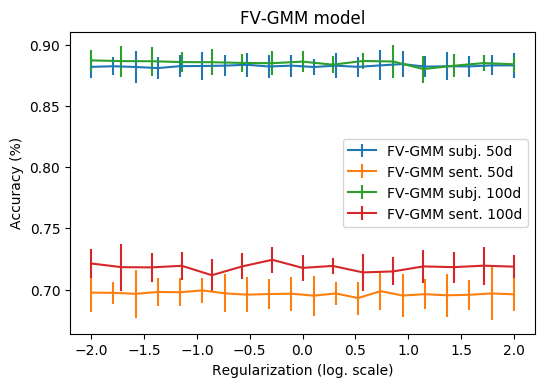

In [28]:
fig = plt.figure(dpi=100)

plt.errorbar(np.log10(df_FVGMM_50.C_val), df_FVGMM_50.acc_subj, yerr=df_FVGMM_50.std_subj, label='FV-GMM subj. 50d')
plt.errorbar(np.log10(df_FVGMM_50.C_val), df_FVGMM_50.acc_MR, yerr=df_FVGMM_50.std_MR, label='FV-GMM sent. 50d')

plt.errorbar(np.log10(df_FVGMM_100.C_val), df_FVGMM_100.acc_subj, yerr=df_FVGMM_100.std_subj, label='FV-GMM subj. 100d')
plt.errorbar(np.log10(df_FVGMM_100.C_val), df_FVGMM_100.acc_MR, yerr=df_FVGMM_100.std_MR, label='FV-GMM sent. 100d')

plt.title('FV-GMM model')
plt.xlabel('Regularization (log. scale)')
plt.ylabel('Accuracy (%)')

plt.legend()
plt.show()

### 6.2 FV-moVMF

In [35]:
# Use 4-fold CV for this example (faster).
subj_res_FVmoVMF = k_fold_FVmoVMF(tok_subj_data, wv_model=w2v_model_subj.wv, n_comp=mix_comp, k=4, reg=1)
sent_res_FVmoVMF = k_fold_FVmoVMF(tok_sent_data, wv_model=w2v_model_sent.wv, n_comp=mix_comp, k=4, reg=1)

print(" ------- FV-moVMF neu ------- \n")
print(np.round(subj_res_FVmoVMF, decimals=3))
print(np.round(sent_res_FVmoVMF, decimals=3))

print("\n")

print("Mean subj. accuracy: {0:.3f} +/- {1:.3f}".format(np.mean(subj_res_FVmoVMF), np.std(subj_res_FVmoVMF)))
print("Mean sent. accuracy: {0:.3f} +/- {1:.3f}".format(np.mean(sent_res_FVmoVMF), np.std(sent_res_FVmoVMF)))

 ------- FV-moVMF neu ------- 

[0.86  0.853 0.85  0.844]
[0.683 0.695 0.702 0.683]


Mean subj. accuracy: 0.852 +/- 0.006
Mean sent. accuracy: 0.691 +/- 0.008


#### Parameter scan - ragularization

In [ ]:
# Try several regularization parameters.

# Here C in [0.01, 100]
a_lim = -2.0  # Lower limit: 10^{-2}
b_lim = 2     # Upper limit: 10^{+2}

reg_values_FVmoVMF_neu = []  # C values for log. regr.
acc_subj_FVmoVMF_neu = []    # mean accuracy on Subj. dataset
std_subj_FVmoVMF_neu = []    # std on Subj. dataset
acc_sent_FVmoVMF_neu = []    # mean accuracy on MR dataset
std_sent_FVmoVMF_neu = []    # std on MR dataset

for i, r_exp in enumerate(np.linspace(a_lim, b_lim, 10)):
    r = 10**r_exp  # log. sampling in [0.01, 100]
    
    if i % 2 == 0:
        print("Processing C = {0:.3f}.".format(r))
    
    subj_res = k_fold_FVmoVMF(tok_subj_data, wv_model=w2v_model_subj.wv, n_comp=mix_comp, k=10, reg=r)
    sent_res = k_fold_FVmoVMF(tok_sent_data, wv_model=w2v_model_sent.wv, n_comp=mix_comp, k=10, reg=r)
    
    reg_values_FVmoVMF_neu.append(r)
    acc_subj_FVmoVMF_neu.append(np.mean(subj_res))
    std_subj_FVmoVMF_neu.append(np.std(subj_res))
    acc_sent_FVmoVMF_neu.append(np.mean(sent_res))
    std_sent_FVmoVMF_neu.append(np.std(sent_res))
    

df_FVmoVMF_neu = pd.DataFrame(list(zip(reg_values_FVmoVMF_neu, acc_subj_FVmoVMF_neu, std_subj_FVmoVMF_neu, 
                                       acc_sent_FVmoVMF_neu, std_sent_FVmoVMF_neu)),
                              columns =['C_val', 'acc_subj', 'std_subj', 'acc_MR', 'std_MR'])

df_FVmoVMF_neu.round(4).to_csv('results/FVmoVMF_acc_reg_100topics.csv', header=True, index=False)

Take a look at the results.

In [36]:
df_FVmoVMF_50 = pd.read_csv("results/FVmoVMF_acc_reg.csv")
df_FVmoVMF_100 = pd.read_csv("results/FVmoVMF_acc_reg_100topics.csv")

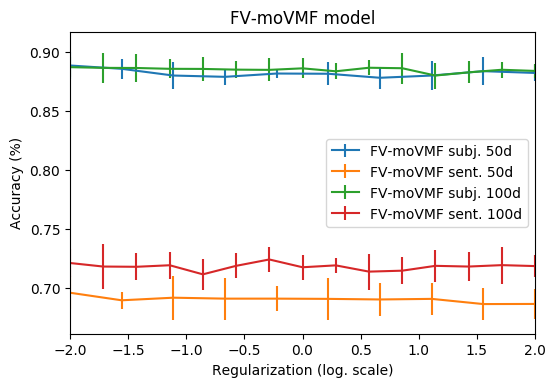

In [38]:
fig = plt.figure(dpi=100)

plt.errorbar(np.log10(df_FVmoVMF_50.C_val), df_FVmoVMF_50.acc_subj, yerr=df_FVmoVMF_50.std_subj, 
             label='FV-moVMF subj. 50d')
plt.errorbar(np.log10(df_FVmoVMF_50.C_val), df_FVmoVMF_50.acc_MR, yerr=df_FVmoVMF_50.std_MR, 
             label='FV-moVMF sent. 50d')

plt.errorbar(np.log10(df_FVGMM_100.C_val), df_FVGMM_100.acc_subj, yerr=df_FVGMM_100.std_subj, 
             label='FV-moVMF subj. 100d')
plt.errorbar(np.log10(df_FVGMM_100.C_val), df_FVGMM_100.acc_MR, yerr=df_FVGMM_100.std_MR, 
             label='FV-moVMF sent. 100d')

plt.xlim(-2, 2)

plt.title('FV-moVMF model')
plt.xlabel('Regularization (log. scale)')
plt.ylabel('Accuracy (%)')

plt.legend()
plt.show()